# Creating Filters to Generate Users Movie Recommendations

By: Michael Hui, Kelly Hwang, Justin Loi, Scott Yuk

## Introduction

This project will create a movie recommendation system based on movie genres by using Python. There are two distinct methods to create a recommendation system: content based filtering and collaborative filtering. We will be focusing on content based filtering and analyzing (including its advantages and disadvantages).

Content-based Filtering works by using item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. In this case, we will be using a movie to get the related genre and recommend other movie selections based on the extracted data. 

Collaborative Filtering works by using users with similar preferences to recommend items to the user. In this case, we will be using other user's rating for a movie to recommend movie selections.

The [movie dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download) used is from from Kaggle.

## Imports

In [1]:
import pandas as pd
import json
import re
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Content-Based Filtering

## Examining The Data

First, lets examine the data

In [2]:
movies = pd.read_csv("dataset/movies_metadata.csv")
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92


In [3]:
print('Num records before removing duplicates: ', len(movies['id']))
movies = movies.drop_duplicates()
print('Num records after removing duplicates: ', len(movies['id']))

Num records before removing duplicates:  45466
Num records after removing duplicates:  45443


Since the dataset includes many fields that will not be impacting our recommendation system, we can remove the usused data columns: ```adult```, ```belongs_to_collection```,```budget```,```homepage```, ```imdb_id```, ```original_title```,```overview```,```poster_path```, ```revenue```, ```runtime```,```spoken_languages```,```tagline```, ```video```, ```vote_count```

In [4]:
movies = movies.drop(
    columns=['adult', 
             'belongs_to_collection',
             'budget',
             'homepage', 
             'imdb_id', 
             'original_title',
             'overview',
             'poster_path', 
             'revenue', 
             'runtime',
             'spoken_languages',
             'tagline', 
             'video', 
             'vote_count'])

movies.head(3)

,genres,id,original_language,popularity,production_companies,production_countries,release_date,status,title,vote_average
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",10/30/1995,Released,Toy Story,7.7
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/15/1995,Released,Jumanji,6.9
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,Released,Grumpier Old Men,6.5


### Cleaning Genres field to something sensible

One data column that needed to be cleaned to be usable was the ```genres``` column. Since the .csv file used single quotes, the ```read_csv``` function converted the intended JSON datatype into a string. As a result, it was necessary to replace all instances of ```'``` with ```"``` and use ```json.loads()``` to convert it into a JSON, then extract each genre.

In [5]:
movies["genres"] = movies["genres"].replace("'", "\"", regex=True)
output = []

for i, jsonStr in enumerate(movies["genres"], 0):
    
    data = json.loads(jsonStr)
    for genre in data:
        output.append(genre['name'])
        
    s = ';'.join(output)
    
    movies["genres"][i] = s
    output = [] 


C:\Users\Mikoto\AppData\Local\Temp\ipykernel_24088\2471152691.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies["genres"][i] = s
C:\Users\Mikoto\AppData\Local\Temp\ipykernel_24088\2471152691.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies["genres"][i] = s
C:\Users\Mikoto\AppData\Local\Temp\ipykernel_24088\2471152691.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies["genres"][i] = s
C:\Users\Mikoto\AppDat

After this cleaning, the genres column should be in the format ```genre1```;```genre2```;```...```

In [6]:
data = movies['genres'][10]
data

'Comedy;Drama;Romance'

In [7]:
number_unique_movies = len(pd.unique(movies['title']))
number_unique_genres = len(pd.unique(movies['genres']))
print("Number of unique movies: ", number_unique_movies)
print("Number of unique genre sets: ", number_unique_genres)

Number of unique movies:  42275
Number of unique genre sets:  4083


## Building Process

The function ```getMovieGenres``` finds the genres based on the inputted movie title. Essentially, the function will loop through each row and return the movie's genre if it is in the dataset or "Movie title not found." if it is not.

Note: The input is case sensitive

In [8]:
def getMovieGenres(movie_name):
    result = []
    genres = ''
    for i, row in  enumerate(movies['title'],0):
        if movie_name == row:
            result = movies.loc[i,:]
            genres = result['genres']
            break
        else:
            genres = "Movie title not found."
    return genres

The function ```recommender``` is the function that returns a list of movies recommendations. 

It does several things
- Check if the movie is in the dataset using the ```getMovieGenres``` function
- Loop the movie with the same genres into a new dataset
- Return 10 movie recommendation (Release Date, Title, Genres, and Average Vote)

In [9]:
def recommender(movietitle):
    index = movies.index
    condition = movies["title"] == movietitle
    movie_index = index[condition].tolist()
    
    if len(movie_index) == 0:
        return "Movie title not found"
    else:
        genres = getMovieGenres(movietitle)
        movie_sort = []
        testmovie = movies
        for i, row in enumerate(testmovie['genres'], 0):
            if genres in row and i != movie_index[0]:
                movie_sort.append(testmovie.loc[i,:])
        
        movie_to_recommend = pd.DataFrame(movie_sort)
        movie_to_recommend = movie_to_recommend[movie_to_recommend['vote_average'] >= 5]
        movie_to_recommend = movie_to_recommend.reset_index()
        movie_to_recommend.index += 1
        movie_to_recommend = movie_to_recommend[["release_date","title","genres","vote_average"]]
        print("10 movie recommendations \n")
        return movie_to_recommend.head(10)

## Testing

Next is testing the functions to ensure that 
- the ```getMovieGenres``` function works
- the ```recommender``` function does return movies with the same genres

In [10]:
print(getMovieGenres("Heat"))
recommender("Heat")

Action;Crime;Drama;Thriller
10 movie recommendations 



,release_date,title,genres,vote_average
1,4/21/1995,Kiss of Death,Action;Crime;Drama;Thriller,5.7
2,11/10/1993,Carlito's Way,Action;Crime;Drama;Thriller,7.7
3,10/1/1993,Killing Zoe,Action;Crime;Drama;Thriller,6.1
4,9/13/1993,Romeo Is Bleeding,Action;Crime;Drama;Thriller,5.7
5,9/20/1996,Last Man Standing,Action;Crime;Drama;Thriller,6.2
6,7/6/1989,The Killer,Action;Crime;Drama;Thriller,7.6
7,4/3/1998,Lost in Space,Drama;Action;Thriller;Crime,5.0
8,8/11/1975,Dog Day Afternoon,Comedy;Drama,7.6
9,8/3/1990,Mo' Better Blues,Drama;Romance,6.3
10,7/10/1979,The Champ,Animation;Comedy;Family,6.7


In [11]:
print(getMovieGenres("Pulp Fiction"))
recommender("Pulp Fiction")

Thriller;Crime
10 movie recommendations 



,release_date,title,genres,vote_average
1,10/20/1995,Get Shorty,Comedy;Thriller;Crime,6.4
2,1/19/1996,From Dusk Till Dawn,Horror;Action;Thriller;Crime,6.9
3,12/9/1994,Disclosure,Drama;Thriller;Crime;Mystery;Romance,5.9
4,9/16/1994,The Glass Shield,Drama;Action;Thriller;Crime,5.4
5,9/14/1994,Leon: The Professional,Thriller;Crime;Drama,8.2
6,4/28/1995,The Underneath,Thriller;Crime,5.6
7,7/20/1994,The Client,Drama;Thriller;Crime;Mystery,6.4
8,8/6/1993,The Fugitive,Adventure;Action;Thriller;Crime;Mystery,7.2
9,7/8/1993,In the Line of Fire,Action;Drama;Thriller;Crime;Mystery,6.8
10,10/15/1993,Judgment Night,Action;Thriller;Crime,6.4


Additionally, it is also important to test that there will be no recommendation in the event that the movie is not in the dataset. 

In [12]:
print(getMovieGenres("Pokemon"))
recommender("Pokemon")

Movie title not found.


'Movie title not found'

## Pro and Con of Content-Based Filtering

Pro:
- Computational Light
- Does not need data about other users
- Captures specific interest of user 
    - Can recommend niche items that few users are interested in

Con:
- Only as good as the hand-engineered feature
    - Requires a lot of domain knowledge (ie movies in this case)
    - Requires accurate data
- Limited in regards of expanding a user's existing interest

## Analysis

### Accuracy

Overall, the results from the content-based filtering was fairly reasonable given the simplicity of the operations.

### Scalability

To make the content-based operations more scalable, we will need to method to filter and store data directly into the matrix used. Even though the matrix would still require a lot of space O(n), it is possible since large companies use a similar approach at a larger scale.

Additionally, it may be possible to reduce the size of the matrix by using a combination of ```mmap()``` and hashing.

# Collabarative Filtering

## Examining the Data

For ```ratings_small.csv``` it has 4 fields: ```userId```, ```movieId```, ```rating```, ```timestamp```.

In [13]:
reviews = pd.read_csv("dataset/ratings_small.csv")
reviews.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


While the following fields are sufficient to do operations, it would be helpful (especially for data visualization) to see which ```title``` corresponds to which ```movieId```.

In [14]:
reviews = pd.merge(reviews, movies, left_on="movieId", right_on='id', how="inner")
reviews.head(3)

,userId,movieId,rating,timestamp,genres,id,original_language,popularity,production_companies,production_countries,release_date,status,title,vote_average
0,1,1371,2.5,1260759135,Drama,1371,en,11.673366,"[{'name': 'United Artists', 'id': 60}]","[{'iso_3166_1': 'US', 'name': 'United States o...",5/28/1982,Released,Rocky III,6.6
1,4,1371,4.0,949810302,Drama,1371,en,11.673366,"[{'name': 'United Artists', 'id': 60}]","[{'iso_3166_1': 'US', 'name': 'United States o...",5/28/1982,Released,Rocky III,6.6
2,7,1371,3.0,851869160,Drama,1371,en,11.673366,"[{'name': 'United Artists', 'id': 60}]","[{'iso_3166_1': 'US', 'name': 'United States o...",5/28/1982,Released,Rocky III,6.6


After joining the two csv files, there are some fields that can be dropped so we extract the 4 most important fields: ```userId```, ```movieId```, ```rating```, ```title```.

In [15]:
reviews = reviews[['userId', 'movieId','rating', 'title']]
reviews.head(3)

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III


In total, there are a large enough number of movies, users, and reviews to analyze.

In [16]:
total_movies = len(pd.unique(reviews['movieId']))
total_users = len(pd.unique(reviews['userId']))
total_reviews = len((reviews['rating']))

print("Total number of movies reviewed: ", total_movies)
print("Total number of user: ", total_users)
print("Total number of reviews: ", total_reviews)

Total number of movies reviewed:  2830
Total number of user:  671
Total number of reviews:  44994


Next we sort the movies by its ```movieId``` and drop the ```userId``` and ```rating``` columns to make a movie directory that will be useful later on.

In [17]:
recommend_df = reviews.sort_values(by=['movieId'])
recommend_df.head()

recommend_df

,userId,movieId,rating,title
22496,496,2,4.0,Ariel
22493,479,2,4.0,Ariel
22492,473,2,5.0,Ariel
22491,471,2,3.0,Ariel
22490,468,2,2.0,Ariel
...,...,...,...,...
33087,15,142507,3.0,Exit
44214,402,148652,2.5,The Eleventh Victim
33088,15,158238,3.5,Stolen Seas
33089,73,158238,4.0,Stolen Seas


In [18]:
movie_directory = recommend_df.drop(columns=['rating', 'userId'])
movie_directory = movie_directory.drop_duplicates()

movie_directory

,movieId,title
22496,2,Ariel
14403,3,Shadows in Paradise
22555,5,Four Rooms
22585,6,Judgment Night
22695,11,Star Wars
...,...,...
33083,140174,Rise of the Zombies
33087,142507,Exit
44214,148652,The Eleventh Victim
33088,158238,Stolen Seas


## Determining a Good Measure for Recommendation

From the available data, the value that we can use to determine if a movie is worth recommending to a user is the ```rating``` column.

The ```rating``` value is expressed as an number between 0.0 and 5.0 in 0.5 intervals. 

Below we sorted the top 10 movies by their mean ```rating``` score. It is clear to see that there is a problem: all of the titles have the highest rating. As a result, we can hypothesize that these titles might only have a few perfect reviews, which is skewing the data. 

In [19]:
recommend_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
The Celebration                     5.0
The Wizard                          5.0
Mr. Magorium's Wonder Emporium      5.0
Frank Herbert's Dune                5.0
The Game                            5.0
The Garden of the Finzi-Continis    5.0
Duel of Hearts                      5.0
The General                         5.0
Singin' in the Rain                 5.0
The Brothers Grimm                  5.0
Name: rating, dtype: float64

As noted in the results below, there are several instances of movies with only 1 review. Therefore, some data cleaning must happen to remove these outliers.

In [20]:
num_of_reviewer = pd.DataFrame(recommend_df.groupby('movieId').mean())
num_of_reviewer['num_of_users'] = pd.DataFrame(recommend_df.groupby('movieId')['userId'].count())
num_of_reviewer = num_of_reviewer.sort_values(by=['num_of_users'],ascending=True)
num_of_reviewer.head()

,userId,rating,num_of_users
movieId,,,
160718,547.0,4.0,1
5125,30.0,2.0,1
5122,30.0,4.0,1
5071,15.0,5.0,1
5063,575.0,2.0,1


Below is a graph of the number of reviewers by movie. It is clear to see that some movies garnered more attention, which results with more reviews.

Text(0, 0.5, 'Number of Users')

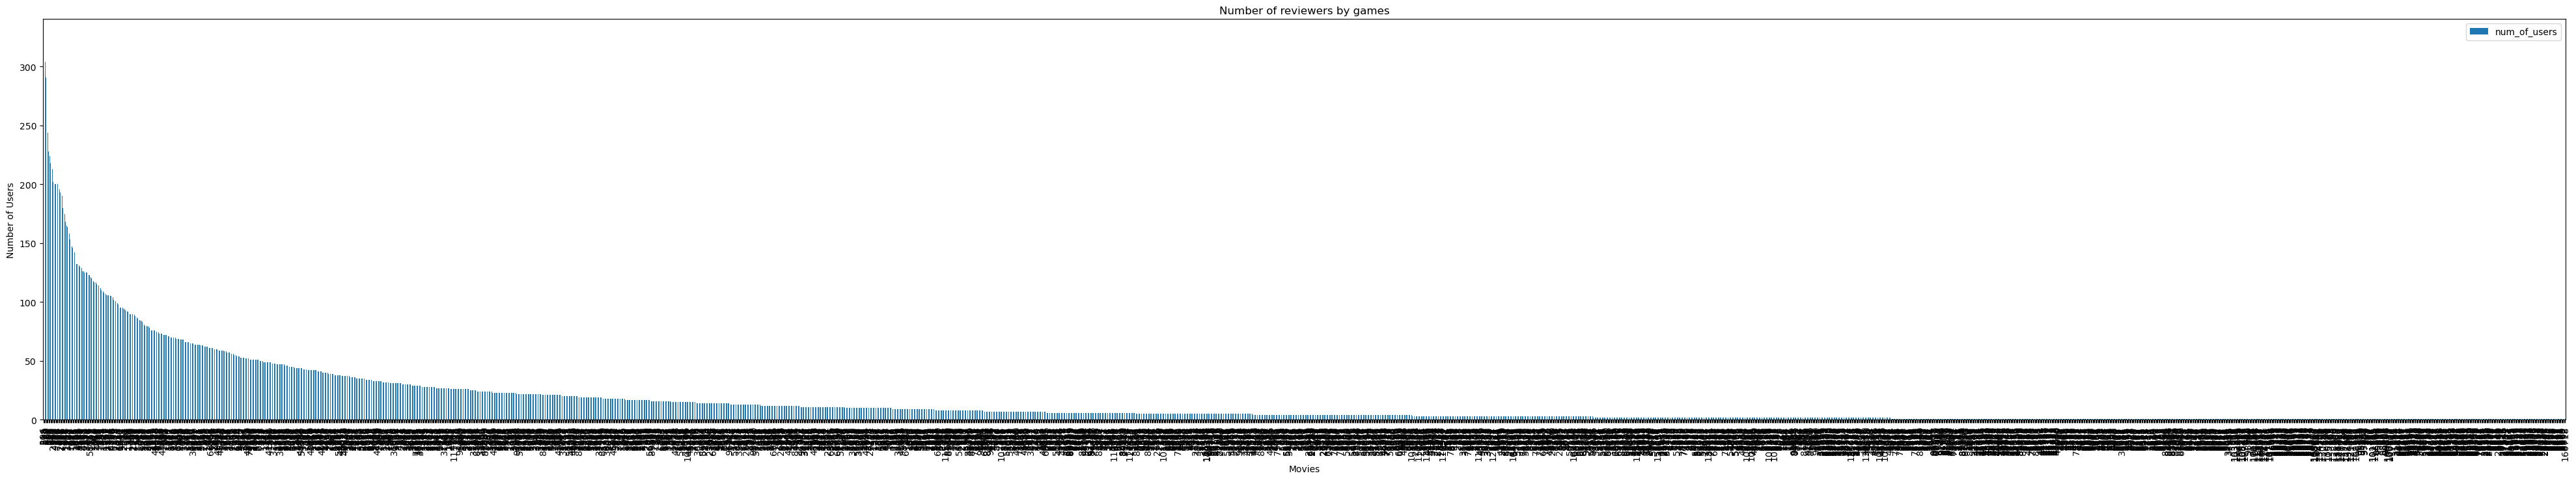

In [21]:
num_of_reviewer_df = num_of_reviewer.drop(columns=['userId', 'rating'])
num_of_reviewer_df = num_of_reviewer_df.sort_values(by=['num_of_users'],ascending=False)
num_of_reviewer_plot = num_of_reviewer_df.plot(kind='bar', figsize=(50, 8), title='Number of reviewers by games')
num_of_reviewer_plot.set_xlabel("Movies")
num_of_reviewer_plot.set_ylabel("Number of Users")

## Applying collaborative filtering to the data 

From the analysis above, some sort of data cleaning must be done if we were the use ```rating``` as our metric. As a result, we will first remove the ```rating``` less than 3 as any movie less than it should not be recommended.

In [22]:
placeholder = pd.DataFrame(recommend_df.groupby('movieId').mean())
placeholder['num_of_users'] = pd.DataFrame(recommend_df.groupby('movieId')['userId'].count())
placeholder.drop(placeholder[placeholder['rating'] < 3].index, inplace = True)
placeholder

,userId,rating,num_of_users
movieId,,,
2,318.906542,3.401869,107
3,374.423729,3.161017,59
5,320.785714,3.267857,56
6,334.096154,3.884615,104
11,353.378049,3.689024,82
...,...,...,...
135536,624.000000,3.000000,1
140174,355.000000,3.900000,5
142507,15.000000,3.000000,1


Aso noted above, there is bias within the data because there are some movies with only 1 reviews. As a result, we should drop any movie that have a "small" number of reviews. In this case, we remove movies with less than 30 reviews due to the Central Limit Theorem. 

In [23]:
placeholder.drop(placeholder[placeholder['num_of_users'] <= 30].index, inplace = True)
placeholder

,userId,rating,num_of_users
movieId,,,
2,318.906542,3.401869,107
3,374.423729,3.161017,59
5,320.785714,3.267857,56
6,334.096154,3.884615,104
11,353.378049,3.689024,82
...,...,...,...
54272,337.351351,3.337838,37
54503,323.204545,3.738636,44
58559,328.446281,4.235537,121


As shown below, there are quite a few NaN values because most users would only have watched a few movies. 

Note: It is necessary to clean the matrix by changing all the NaN values to be 0. 

In [24]:
movie_matrix = placeholder.pivot_table(index ='movieId',columns ='userId', values ='rating')
movie_matrix.fillna(0,inplace=True)
movie_matrix

userId,258.088889,282.027778,284.973684,286.632653,296.085106,296.404255,297.939394,299.290323,299.475000,300.366197,...,389.584615,390.357143,390.815789,392.090909,397.000000,401.515152,409.564103,409.673469,412.333333,417.193548
movieId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice how the resulting matrix is 369 rows x 369 columns and that many of the values are 0.

As a result, we can try solve this problem of space inefficiency and extra overhead time to compute analysis by using the ```scipy.sparse``` to compress the sparse matrix into duples of indices and values.

In [25]:
csr_data = csr_matrix(movie_matrix.values)
movie_matrix.reset_index(inplace=True)
print(csr_data)

  (0, 48)	3.4018691588785046
  (1, 338)	3.1610169491525424
  (2, 54)	3.267857142857143
  (3, 147)	3.8846153846153846
  (4, 266)	3.6890243902439024
  (5, 135)	3.4516129032258065
  (6, 51)	3.9488636363636362
  (7, 330)	3.9244186046511627
  (8, 44)	3.536842105263158
  (9, 361)	3.3552631578947367
  (10, 363)	3.0441176470588234
  (11, 245)	3.742574257425743
  (12, 177)	4.0
  (13, 249)	3.689655172413793
  (14, 130)	3.0208333333333335
  (15, 64)	3.1774193548387095
  (16, 55)	3.2925531914893615
  (17, 349)	3.1145833333333335
  (18, 67)	3.9451754385964914
  (19, 119)	4.22457627118644
  (20, 3)	3.295918367346939
  (21, 133)	3.5806451612903225
  (22, 49)	3.2790697674418605
  (23, 274)	3.9025
  (24, 323)	3.83125
  :	:
  (344, 25)	3.8714285714285714
  (345, 244)	3.861111111111111
  (346, 66)	3.8513513513513513
  (347, 359)	3.7
  (348, 340)	3.1808510638297873
  (349, 106)	4.0
  (350, 7)	3.6774193548387095
  (351, 267)	3.8813559322033897
  (352, 314)	3.880952380952381
  (353, 315)	3.4591836734693877


We can the ```sklearn``` library to process this list of indicies and values to calculate similarity by using cosine similarity. The result would be a list of indicies and distances that can be sorted to find other indexes with similarity.

In [26]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

Finally, we can use k-nearest neighbors to find and sort the top 10 most similar movies with their indices and distances. 

Note: There are issues with these results but we will discuss why later.

In [27]:
distances , indices = knn.kneighbors(csr_data[0],11)
print("10 movie recommendations")
print("Movie ID | Distance")

rec_game_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
rec_game_indices

10 movie recommendations
Movie ID | Distance


[(242, 1.0),
 (245, 1.0),
 (246, 1.0),
 (247, 1.0),
 (248, 1.0),
 (249, 1.0),
 (250, 1.0),
 (251, 1.0),
 (252, 1.0),
 (244, 1.0)]

##  Pro and Con of Collaborative Filtering

Pro:
- Does not require domain knowledge
- Able to discover new interests based on other users
- More diversity between items

Con:
- Requires more user data
    - This is where results went wrong

## Analysis 

### Accuracy

As noted above, there are issues with the results. We believe the resulting similarities are all 1.0 due to the small interval between the `rating` values. If mapped out on a space, all of the values would be clustered very closely due to the closeness between 0 and 5. 

As a result, some solutions we propose
- Multiply ```rating``` by a value that would allow the points to be differentiated into different clusters
- Use a different field that 
    - has a value for each user for each movie
    - Continuous with a wide range of values

### Scalability

For the collaborative filtering, the system should be able to scale by adding more movies with the appropriate data. However, there will also be the difficulties due to the high ram usage. 

## Conclusion 

For our group, the project was definitely a struggle. In the beginning, our group wanted to look for a dataset that we had a good understanding of. Due to those specifications, we ended up with Movies. Looking through the data. In the beginning, we wanted to determine which fields had a correlation to a movie's success with KNN. After more consideration and thinking, it was impossible given our data. We ultimately decided to go with a recommendation algorithm. 

With what we researched we found there were three different filtering methods: Content-based, Collaborative, and Hybrid. The original plan was to do Hybrid filtering along with the other two filters, but after discovering issues with our dataset. We decided to exclude Hybrid filtering due to the lack of requirements. 

When doing the **Content-based filter** our group found it easier than expected to complete. We had clean the data in the genre field and feed it into functions that would be able to find similar genres in movies. The output returns movies similar to that genre. However, there is room for improvement as we can filter the data further to get an accurate output. 

In regards to **Collaborative filtering** this was the most difficult as midway we found out our data for reviews was not good enough. The values for rating were too small (ranging from 0 - 5, with 0.5 increments). This caused our KNN search to classify all the points as a single cluster. There is also the problem of the ratings being discrete variables. Since there are only 10 unique values, when trying to scale the KNN the data points would overlap on top of each other.

If we had more time:
 - Improve filtering (perhaps on voter_average and genres) for content-based filter results 
 - Hash map to decrease computation required


## References

Inspiration for the Project: https://www.analyticsvidhya.com/blog/2020/08/recommendation-system-k-nearest-neighbors/

Dataset Used: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download